**Connecting to Google drive**

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-95ece42e-19bc-7d95-4a3e-c448d1ef8bf9)


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#Extracting file from gdrive into colab
!pip3 install patool
import patoolib
patoolib.extract_archive("/content/gdrive/MyDrive/plant disease detection project/brinjal_chili_dataset/brinjal_chilli_model_data.rar",
                         outdir="/content/")

     |████████████████████████████████| 77 kB 2.8 MB/s 
patool: Extracting /content/gdrive/MyDrive/plant disease detection project/brinjal_chili_dataset/brinjal_chilli_model_data.rar ...
patool: running /usr/bin/unrar x -- "/content/gdrive/MyDrive/plant disease detection project/brinjal_chili_dataset/brinjal_chilli_model_data.rar"
patool:     with cwd='/content/'
patool: ... /content/gdrive/MyDrive/plant disease detection project/brinjal_chili_dataset/brinjal_chilli_model_data.rar extracted to `/content/'.


'/content/'

In [ ]:
 %tensorflow_version 2.x
import tensorflow as tf
import os
import numpy as np
import pandas as pd

In [ ]:
dir_path = "/content/brinjal_chilli_model_data"

In [ ]:
#importing pathlib
#please check https://docs.python.org/3/library/pathlib.html  to know about pathlib
import pathlib
data_root = pathlib.Path(dir_path)
print(data_root)

/content/brinjal_chilli_model_data


In [ ]:
import glob
from multiprocessing import Pool
from PIL import Image

def CheckOne(f):
    try:
        im = Image.open(f)
        im.verify()
        im.close()
        return
    except (IOError, OSError, Image.DecompressionBombError):
        return f


p = Pool()
files = [f for f in data_root.glob('*/*')]
print(f"Files to be checked: {len(files)}")

# Map the list of files to check onto the Pool
corrupted_files = p.map(CheckOne, files)

# Filter out None values representing files that are ok, leaving just corrupt ones
corrupted_files = list(filter(None, corrupted_files)) 
print(f"Num corrupt files: {len(corrupted_files)}")
corrupted_files


Files to be checked: 1705
Num corrupt files: 0


[]

In [ ]:
for file in corrupted_files :
  os.remove(file) 

In [ ]:
##getting all the directories
list(data_root.iterdir())

[PosixPath('/content/brinjal_chilli_model_data/Brinjal'),
 PosixPath('/content/brinjal_chilli_model_data/.ipynb_checkpoints'),
 PosixPath('/content/brinjal_chilli_model_data/Chilli')]

In [ ]:

##Getting all image paths
import random
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
# ##shuffling the images 
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

1705

In [ ]:
all_image_paths[:6]

['/content/brinjal_chilli_model_data/Chilli/IMG_20220419_162430.jpg',
 '/content/brinjal_chilli_model_data/Chilli/IMG_20220411_111922.jpg',
 '/content/brinjal_chilli_model_data/Chilli/IMG_20220411_110651.jpg',
 '/content/brinjal_chilli_model_data/Brinjal/IMG_20220425_173455.jpg',
 '/content/brinjal_chilli_model_data/Brinjal/IMG_20220425_173401.jpg',
 '/content/brinjal_chilli_model_data/Chilli/IMG_20220425_172537.jpg']

In [ ]:
#List the available labels
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())[1:]
label_names

['Brinjal', 'Chilli']

In [ ]:
label_to_index = dict((name, index) for index,name in enumerate(label_names))
label_to_index

{'Brinjal': 0, 'Chilli': 1}

In [ ]:
#Create a list of every file, and its label index
all_image_labels = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]
all_image_labels[0:10]

[1, 1, 1, 0, 0, 1, 1, 1, 1, 0]

**Train  test cv split and shuffle**

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(all_image_paths, all_image_labels ,test_size=0.10, train_size=0.90, shuffle = True, stratify =all_image_labels )
# x_test, x_cv, y_test, y_cv = train_test_split(x, y, test_size = 0.50,train_size =0.50, shuffle = True)

In [ ]:
print("training size:",len(x_train))
# print("cross val size:",len(x_cv))
print("testing size:",len(x_test))

training size: 1534
testing size: 171


In [ ]:

steps_per_epoch_tr=np.ceil(len(x_train)/32)
steps_per_epoch_te=np.ceil(len(x_test)/4)

# steps_per_epoch_cv=np.ceil(len(x_cv)/32)
steps_per_epoch_tr

48.0

In [ ]:
def tfdata_generator(images, labels, is_training, batch_size=32):
    '''Construct a data generator using tf.Dataset'''
    
    def parse_function(filename, label):
        #reading path 
        image_string = tf.io.read_file(filename)
        #decoding image
        image = tf.image.decode_jpeg(image_string, channels=3)

        # This will convert to float values in [0, 1]
        image = tf.image.convert_image_dtype(image, tf.float32)
        #resize the image
        image = tf.image.resize(image, [224, 224])
        #one hot coding for label
        y = tf.one_hot(tf.cast(label, tf.uint8), 2)
        return image, y
    
    def flip(image,labels):
        
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        
        return image,labels

    # def zoom(image, labels):
    #     image = tf.image.central_crop(image,central_fraction=0.8)
    #     return image, labels
    
    def rotate(image,labels):

        return tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)), labels
    
    def color(image,labels):
        image = tf.image.random_hue(image, 0.08)
        image = tf.image.random_saturation(image, 0.6, 1.6)
        image = tf.image.random_brightness(image, 0.05)
        image = tf.image.random_contrast(image, 0.7, 1.3)
        return image,labels

    
    ##creating a dataset from tensorslices
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    
    if is_training:
        dataset = dataset.shuffle(len(all_image_paths))  # depends on sample size


    # Transform and batch data at the same time
    dataset = dataset.map(parse_function,  num_parallel_calls=4)

    augmentations = [flip, rotate, color]
    if is_training:   
        for augmentation in augmentations:
            if np.random.uniform(0, 1) < 0.5:
                dataset = dataset.map(augmentation, num_parallel_calls=4)


    dataset = dataset.batch(batch_size, drop_remainder=True if is_training else False)  \
                      .repeat()  \
                      .prefetch(tf.data.AUTOTUNE)  \
                      .cache()

    return dataset

In [ ]:
# all_dataset = tfdata_generator(all_image_paths, all_image_labels, is_training=True, batch_size=32)

In [ ]:
#creating a generator
tr_dataset = tfdata_generator(x_train, y_train, is_training=True, batch_size=32)
# cv_dataset = tfdata_generator(x_cv, y_cv, is_training=True, batch_size=32)
te_dataset = tfdata_generator(x_test, y_test, is_training=True, batch_size=4)

In [ ]:
##Time taken to load the images
import time
t = 0
start = time.time()
for x, y in tr_dataset.take(steps_per_epoch_tr):
    pass
end = time.time()
duration = end-start
print("{} batches: {} s".format(steps_per_epoch_tr, duration))
print("{:0.5f} Images/s".format(32*steps_per_epoch_tr/duration))

KeyboardInterrupt: ignored

In [ ]:
# import os
# os.environ['PYTHONHASHSEED'] = '0'

# ##https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
# ## Have to clear the session. If you are not clearing, Graph will create again and again and graph size will increses. 
# ## Varibles will also set to some value from before session
# tf.keras.backend.clear_session()

# ## Set the random seed values to regenerate the model.
# np.random.seed(0)
# rn.seed(0)

# #Input layer
# input_layer = Input(shape=(256,256,3),name='Input_Layer')

# #Conv Layer
# Conv1 = Conv2D(filters=32,kernel_size=(3,3),strides=(1,1),padding='valid',data_format='channels_last',
#               activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=0),name='Conv1')(input_layer)
# #MaxPool Layer
# Pool1 = MaxPool2D(pool_size=(2,2),strides=(2,2),padding='valid',data_format='channels_last',name='Pool1')(Conv1)


# Conv2 = Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),padding='valid',data_format='channels_last',
#               activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=3),name='Conv2')(Pool1)
# Conv3 = Conv2D(filters=64,kernel_size=(3,3),strides=(2,2),padding='valid',data_format='channels_last',
#               activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=5),name='Conv3')(Conv2)
# #MaxPool Layer
# Pool2 = MaxPool2D(pool_size=(2,2),strides=(1,1),padding='valid',data_format='channels_last',name='Pool2')(Conv3)


# Conv4 = Conv2D(filters=128,kernel_size=(3,3),strides=(2,2),padding='valid',data_format='channels_last',
#               activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=9),name='Conv4')(Pool2)
# #MaxPool Layer
# Pool3 = MaxPool2D(pool_size=(2,2),strides=(2,2),padding='valid',data_format='channels_last',name='Pool3')(Conv4)



# #Flatten
# flatten = Flatten(data_format='channels_last',name='Flatten')(Pool3)

# #FC layer
# FC1 = Dense(units=30,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=32),name='FC1')(flatten)

# #FC layer
# FC2 = Dense(units=15,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=33),name='FC2')(FC1)

# #output layer
# Out = Dense(units=2, activation='softmax',kernel_initializer=tf.keras.initializers.glorot_normal(seed=3),name='Output')(FC2)

# #Creating a model
# model = Model(inputs=input_layer,outputs=Out)

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),loss='categorical_crossentropy',metrics=['accuracy'])

### **Callbacks**

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

def is_weights_invalid(model_weights, epoch):
    if model_weights is not None:
        if np.any([np.any(np.isnan(x)) for x in model_weights]):
            print("\nInvalid weights and terminated at epoch {}".format(epoch))
            return True
    return False

def is_loss_invalid(loss, epoch):
    if loss is not None:
        if np.isnan(loss) or np.isinf(loss):
            print("\nInvalid loss and terminated at epoch {}".format(epoch))
            return True
    return False



#Write your own callback function, that has to print the micro F1 score and AUC score after each epoch.
#Save your model at every epoch if your validation accuracy is improved from previous epoch.
      
from sklearn.metrics import recall_score

class LossHistory(tf.keras.callbacks.Callback):
    
    def __init__(self,validation_data):
        self.x_cv = validation_data[0]
        print(validation_data[0])
        self.y_cv= validation_data[1]
        
    def on_train_begin(self, logs={}):
        ## on begin of training, we are creating a instance varible called history
        ## it is a dict with keys [loss, acc, val_loss, val_acc]
        self.history={'loss': [],'accuracy': [],'val_loss': [],'val_accuracy': [],'val_auc': [] , 'val_f1':[]}
        
    def on_epoch_end(self, epoch, logs={}):
        
        # If you are getting any NaN values(either weigths or loss) while training, you have to terminate your training.
        loss = logs.get('loss')
        model_weights = self.model.get_weights()
        
        
        if is_weights_invalid(model_weights, epoch) or is_loss_invalid(loss, epoch):
            self.model.stop_training = True

        true_positives=0
        ## on end of each epoch, we will get logs and update the self.history dict
        self.history['loss'].append(logs.get('loss'))
        self.history['accuracy'].append(logs.get('accuracy'))
      
        if logs.get('val_loss', -1) != -1:
            self.history['val_loss'].append(logs.get('val_loss'))
        if logs.get('val_accuracy', -1) != -1:
            self.history['val_accuracy'].append(logs.get('val_accuracy'))

        y_pred= self.model.predict(self.x_cv)
        y_label_pred=np.argmax(y_pred,axis=1)

        
        auc = roc_auc_score(y_cv, y_label_pred,average='micro')
        f1 = f1_score(y_cv, y_label_pred,average='micro')
        
        
        self.history['val_auc'].append(auc)
        self.history['val_f1'].append(f1)


        print('\nauc: ',auc)
        print('f1: ',f1)
        print("\n")
        
     

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler


#  Cond1. If your validation accuracy at that epoch is less than previous epoch accuracy, you have to decrese the
#         learning rate by 10%. 

decay = 0.1
reduceLROnPlateau = tf.keras.callbacks.ReduceLROnPlateau(
  monitor='val_accuracy',
  factor= 1-decay,
  patience=0,
  cooldown = 0,
  verbose = 2
)


#  Cond2. For every 3rd epoch, decay your learning rate by 5%.

def changeLearningRate(epoch, lr):
    if epoch%3==0 and epoch!=0:
        decay = 0.05
        decayed_lr = lr*(1-decay)
        return decayed_lr
    return lr


lrschedule = LearningRateScheduler(changeLearningRate, verbose=0)



In [ ]:
#callbacks
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
import datetime




#Write your own callback function, that has to print the micro F1 score and AUC score after each epoch.
#Save your model at every epoch if your validation accuracy is improved from previous epoch.
# history_own =LossHistory(validation_data=[x_cv, y_cv])   



# Save your model at every epoch if your validation accuracy is improved from previous epoch.
# ---------->  Checkpoint Best Neural Network Model saved Only in the same location i.e it is overwritten
# filepath="model_save_final/weights.best.hdf5"
# ---------->  Checkpoint of Neural Network Model saved only if there are improvements
filepath="model_save_final/mobileNet_v3/weights-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')



# You have to stop the training if your validation accuracy 
# is not increased ( |prev_acc - current_acc| <= 0.0---> considered no improvement here) 
# in last 2 epochs==> (patience=2).
# Often, the first sign of no further improvement may not be the best time to stop training. 
# This is because the model may coast into a plateau of no improvement 
# or even get slightly worse before getting much better. ==> (patient should be high)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=2, mode = 'min')



lrschedule = LearningRateScheduler(changeLearningRate, verbose=0)



#tensor board logging/viz
log_dir = os.path.join("logs",'fits', "mobileNet_v3",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)



#all callbacks
# callbacks=[history_own, checkpoint, lrschedule, reduceLROnPlateau, earlystop, tensorboard_callback]
callbacks=[checkpoint, lrschedule, reduceLROnPlateau, earlystop, tensorboard_callback]


In [ ]:
#importing tensorflow
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Activation,Dropout,Flatten, BatchNormalization, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import random as rn
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns


### **VGG16**

In [ ]:
import os
os.environ['PYTHONHASHSEED'] = '0'

##https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
## Have to clear the session. If you are not clearing, Graph will create again and again and graph size will increses. 
## Varibles will also set to some value from before session
tf.keras.backend.clear_session()

## Set the random seed values to regenerate the model.
np.random.seed(0)
rn.seed(0)

vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape= (224,224, 3))

# Freezing 1st 13 VGG16 weights.
for i, layer in enumerate(vgg16_base.layers[:13]):
  layer.trainable = False

vgg16_base_output = vgg16_base.output

# Conv1 = Conv2D(filters = 64,
#                kernel_size=(7,7),strides=(1,1),
#                padding='valid' , data_format='channels_last',
#                activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=0),name='Conv1',
#                kernel_regularizer=regularizers.l1(0.01), bias_regularizer=regularizers.l2(0.01)
#                 )(vgg16_base_output)


bn = BatchNormalization()(vgg16_base_output)

dropout = Dropout(rate = 0.50, noise_shape=None, seed=6)(bn)


# Conv2 = Conv2D(filters=32,kernel_size=(1,1),strides=(1,1), padding='valid',data_format='channels_last',
#               activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=0),name='Conv2')(dropout)

# bn1 = BatchNormalization()(Conv2)


# Conv3 = Conv2D(filters=16, kernel_size=(1, 1),strides=(1,1), padding='valid',data_format='channels_last',
#               activation='softmax',kernel_initializer=tf.keras.initializers.he_normal(seed=33),name='Conv3')(bn1)

flatten = Flatten(data_format='channels_last',name='Flatten')(dropout)

# bn1 = BatchNormalization()(flatten)

#FC layer
Out = Dense(units=2, activation='softmax',
            kernel_initializer=tf.keras.initializers.HeNormal(seed=32), 
            name='output',
            kernel_regularizer=regularizers.l1(0.01), bias_regularizer=regularizers.l2(0.01) )(flatten)

model = Model(inputs=vgg16_base.input, outputs=Out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
#compiling 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
##fitting generator
model.fit(tr_dataset, 
          steps_per_epoch=steps_per_epoch_tr, 
          epochs=15, validation_data = cv_dataset,
          validation_steps=steps_per_epoch_cv, 
          callbacks=callbacks,
          verbose=1)

Epoch 1/15
24/24 [==============================] - ETA: 0s - loss: 19.0680 - accuracy: 0.6628
Epoch 1: val_accuracy improved from -inf to 0.58333, saving model to model_save_final/vgg16_1/weights-01-0.58.hdf5
24/24 [==============================] - 70s 2s/step - loss: 19.0680 - accuracy: 0.6628 - val_loss: 128.7969 - val_accuracy: 0.5833 - lr: 0.0100
Epoch 2/15
24/24 [==============================] - ETA: 0s - loss: 12.1039 - accuracy: 0.7878
Epoch 2: val_accuracy did not improve from 0.58333

Epoch 2: ReduceLROnPlateau reducing learning rate to 0.008999999798834325.
24/24 [==============================] - 55s 2s/step - loss: 12.1039 - accuracy: 0.7878 - val_loss: 122.4327 - val_accuracy: 0.4167 - lr: 0.0100
Epoch 3/15
24/24 [==============================] - ETA: 0s - loss: 6.9516 - accuracy: 0.8646
Epoch 3: val_accuracy improved from 0.58333 to 0.66667, saving model to model_save_final/vgg16_1/weights-03-0.67.hdf5
24/24 [==============================] - 57s 2s/step - loss: 6.951

### **MOBILENET**

In [ ]:
# TF2 version
#1st attempt 98 acc
import tensorflow.compat.v2 as tf
import tensorflow_hub as hub

import os
os.environ['PYTHONHASHSEED'] = '0'

##https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
## Have to clear the session. If you are not clearing, Graph will create again and again and graph size will increses. 
## Varibles will also set to some value from before session
tf.keras.backend.clear_session()

## Set the random seed values to regenerate the model.
np.random.seed(0)
rn.seed(0)

model = m = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", input_shape=(224,224,3), trainable=False),  # Can be True, see below.
    Dropout(0.3),
    Dense(units=32,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=32),name='FC1'),
    Dense(units=16,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=33),name='FC2'),
    Dense(units=2, activation='softmax',
            kernel_initializer=tf.keras.initializers.HeNormal(seed=32), 
            name='output',
            kernel_regularizer=regularizers.l1(0.01), bias_regularizer=regularizers.l2(0.01) )
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 FC1 (Dense)                 (None, 32)                40992     
                                                                 
 FC2 (Dense)                 (None, 16)                528       
                                                                 
 output (Dense)              (None, 2)                 34        
                                                                 
Total params: 2,299,538
Trainable params: 41,554
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
#compiling 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
##fitting generator
model.fit(tr_dataset, 
          steps_per_epoch=steps_per_epoch_tr, 
          epochs=15, validation_data = te_dataset,
          validation_steps=steps_per_epoch_te, 
          callbacks=callbacks,
          verbose=1)

Epoch 1/15
24/24 [==============================] - ETA: 0s - loss: 1.7949 - accuracy: 0.9141
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to model_save_final/vgg16_1/weights-01-1.00.hdf5
24/24 [==============================] - 77s 2s/step - loss: 1.7949 - accuracy: 0.9141 - val_loss: 1.0083 - val_accuracy: 1.0000 - lr: 0.0080
Epoch 2/15
24/24 [==============================] - ETA: 0s - loss: 1.0102 - accuracy: 0.9857
Epoch 2: val_accuracy did not improve from 1.00000

Epoch 2: ReduceLROnPlateau reducing learning rate to 0.007200000341981649.
24/24 [==============================] - 53s 2s/step - loss: 1.0102 - accuracy: 0.9857 - val_loss: 0.7573 - val_accuracy: 1.0000 - lr: 0.0080
Epoch 3/15
24/24 [==============================] - ETA: 0s - loss: 0.6547 - accuracy: 0.9987
Epoch 3: val_accuracy did not improve from 1.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.006480000307783485.
24/24 [==============================] - 55s 2s/step - loss: 0.65

## MobileNet V3 custom

In [ ]:

# TF2 version
import tensorflow.compat.v2 as tf
import tensorflow_hub as hub

import os
os.environ['PYTHONHASHSEED'] = '0'

##https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
## Have to clear the session. If you are not clearing, Graph will create again and again and graph size will increses. 
## Varibles will also set to some value from before session
tf.keras.backend.clear_session()

## Set the random seed values to regenerate the model.
np.random.seed(0)
rn.seed(0)

model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/experts/bit/r50x1/in21k/plant/1"),
    Dropout(0.2),
    # Dense(units=32,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=32),name='FC1'),
    # Dense(units=16,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=33),name='FC2'),
    Dense(units=2, activation='softmax',
            kernel_initializer=tf.keras.initializers.HeNormal(seed=32), 
            name='output',
            kernel_regularizer=regularizers.l1(0.01), bias_regularizer=regularizers.l2(0.01) )
])
model.build([32, 224,244,3])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (32, 2048)                23500352  
                                                                 
 dropout (Dropout)           (32, 2048)                0         
                                                                 
 output (Dense)              (32, 2)                   4098      
                                                                 
Total params: 23,504,450
Trainable params: 4,098
Non-trainable params: 23,500,352
_________________________________________________________________


In [ ]:
!pip install keras-tuner

In [ ]:
import keras
METRICS = [
      # keras.metrics.TruePositives(name='tp'),
      # keras.metrics.FalsePositives(name='fp'),
      # keras.metrics.TrueNegatives(name='tn'),
      # keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      # keras.metrics.Precision(name='precision'),
      # keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc')
]

# **Hyper-Param tuning MobileNetV3**

In [ ]:

# TF2 version
# try 2
import tensorflow.compat.v2 as tf
import tensorflow_hub as hub

import os
os.environ['PYTHONHASHSEED'] = '0'

##https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
## Have to clear the session. If you are not clearing, Graph will create again and again and graph size will increses. 
## Varibles will also set to some value from before session
tf.keras.backend.clear_session()

## Set the random seed values to regenerate the model.
np.random.seed(0)
rn.seed(0)

def build_model(hp):  
      model = tf.keras.Sequential([
          hub.KerasLayer("https://tfhub.dev/google/experts/bit/r50x1/in21k/plant/1"),
          Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)),
          # Dense(units=32,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=32),name='FC1'),
          # Dense(units=16,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=33),name='FC2'),
          Dense(units=2, activation='softmax',
                  kernel_initializer=tf.keras.initializers.HeNormal(seed=32), 
                  name='output',
                  kernel_regularizer=regularizers.l1(0.01), bias_regularizer=regularizers.l2(0.01) )
      ])

      model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[ 0.01, 0.02, 0.05])),
              loss='categorical_crossentropy',
              metrics=METRICS
              )
      
      return model


In [ ]:
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters


tuner_search=RandomSearch(build_model,
                          objective='val_loss',
                          max_trials = 40, directory='output',project_name="disease detection")

INFO:tensorflow:Reloading Oracle from existing project output/disease detection/oracle.json


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  """Entry point for launching an IPython kernel.
INFO:tensorflow:Reloading Oracle from existing project output/disease detection/oracle.json


KeyboardInterrupt: ignored

In [ ]:

tuner_search.search(tr_dataset, 
          steps_per_epoch=steps_per_epoch_tr, 
          epochs=3, validation_data = cv_dataset,
          validation_steps=steps_per_epoch_cv, 
    )

In [ ]:
best_hps = tuner_search.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('dropout')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

# **Quantization aware training and Pruning***

In [ ]:
!pip3 install -q tensorflow-model-optimization
import tensorflow_model_optimization as tfmot

     |████████████████████████████████| 237 kB 5.2 MB/s 


In [ ]:
#compiling 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

##fitting generator
model.fit(tr_dataset, 
          steps_per_epoch=steps_per_epoch_tr, 
          epochs=1, validation_data = te_dataset,
          validation_steps=steps_per_epoch_te, 
          callbacks=callbacks,
          verbose=1)

48/48 [==============================] - ETA: 0s - loss: 1.8376 - accuracy: 0.9453
Epoch 1: val_loss improved from inf to 1.46879, saving model to model_save_final/mobileNet_v3/weights-01-0.97.hdf5
48/48 [==============================] - 143s 3s/step - loss: 1.8376 - accuracy: 0.9453 - val_loss: 1.4688 - val_accuracy: 0.9709 - lr: 0.0100


**Clone and fine-tune pre-trained model with quantization aware training**

In [ ]:
LastValueQuantizer = tfmot.quantization.keras.quantizers.LastValueQuantizer
MovingAverageQuantizer = tfmot.quantization.keras.quantizers.MovingAverageQuantizer

class DefaultDenseQuantizeConfig(tfmot.quantization.keras.QuantizeConfig):
    # Configure how to quantize weights.
    def get_weights_and_quantizers(self, layer):
      return [(layer.kernel, LastValueQuantizer(num_bits=8, symmetric=True, narrow_range=False, per_axis=False))]

    # Configure how to quantize activations.
    def get_activations_and_quantizers(self, layer):
      return [(layer.activation, MovingAverageQuantizer(num_bits=8, symmetric=False, narrow_range=False, per_axis=False))]

    def set_quantize_weights(self, layer, quantize_weights):
      # Add this line for each item returned in `get_weights_and_quantizers`
      # , in the same order
      layer.kernel = quantize_weights[0]

    def set_quantize_activations(self, layer, quantize_activations):
      # Add this line for each item returned in `get_activations_and_quantizers`
      # , in the same order.
      layer.activation = quantize_activations[0]

    # Configure how to quantize outputs (may be equivalent to activations).
    def get_output_quantizers(self, layer):
      return []

    def get_config(self):
      return {}

In [ ]:

# TF2 version
import tensorflow.compat.v2 as tf
import tensorflow_hub as hub

import os
os.environ['PYTHONHASHSEED'] = '0'

##https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
## Have to clear the session. If you are not clearing, Graph will create again and again and graph size will increses. 
## Varibles will also set to some value from before session
tf.keras.backend.clear_session()

## Set the random seed values to regenerate the model.
np.random.seed(0)
rn.seed(0)


input = tf.keras.layers.Input(shape = (224,224,3))
mobile_net = hub.KerasLayer("https://tfhub.dev/google/experts/bit/r50x1/in21k/plant/1")

transfer_layer = mobile_net(input)
dropout= Dropout(0.2)(transfer_layer)
output = Dense(units=2, activation='softmax',
            kernel_initializer=tf.keras.initializers.HeNormal(seed=32), 
            name='output',
            kernel_regularizer=regularizers.l1(0.01), bias_regularizer=regularizers.l2(0.01) )(dropout)
model = tf.keras.Model(input,output,name = 'Transfer_learning_USE')
model.summary()


Model: "Transfer_learning_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 keras_layer (KerasLayer)    (None, 2048)              23500352  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 output (Dense)              (None, 2)                 4098      
                                                                 
Total params: 23,504,450
Trainable params: 4,098
Non-trainable params: 23,500,352
_________________________________________________________________


In [ ]:
import tensorflow_model_optimization as tfmot

quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model)

# `quantize_model` requires a recompile.
q_aware_model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer='adam', 
              metrics=['accuracy'])


ValueError: ignored

In [ ]:
quantize_annotate_layer = tfmot.quantization.keras.quantize_annotate_layer
quantize_annotate_model = tfmot.quantization.keras.quantize_annotate_model
quantize_scope = tfmot.quantization.keras.quantize_scope

class ModifiedDenseQuantizeConfig(DefaultDenseQuantizeConfig):
    # Configure weights to quantize with 4-bit instead of 8-bits.
    def get_weights_and_quantizers(self, layer):
      return [(layer.kernel, LastValueQuantizer(num_bits=4, symmetric=True, narrow_range=False, per_axis=False))]

model = quantize_annotate_model(model)

model.build([32, 224,244,3])

with quantize_scope({}):
  # Use `quantize_apply` to actually make the model quantization aware.
  quant_aware_model = tfmot.quantization.keras.quantize_apply(model)

quant_aware_model.summary()

ValueError: ignored

## **Pruning**

In [ ]:
import tensorflow_model_optimization as tfmot
initial_sparsity = 0.0
final_sparsity = 0.75
begin_step = 1000
end_step = 5000
pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
            initial_sparsity=initial_sparsity,
            final_sparsity=final_sparsity,
            begin_step=begin_step,
            end_step=end_step)
    }
model = tfmot.sparsity.keras.prune_low_magnitude(model, pruning_params)
pruning_callback = tfmot.sparsity.keras.UpdatePruningStep()

ValueError: ignored

**Train and evaluate the model**

In [ ]:
from sklearn.model_selection import KFold
#compiling 

q_aware_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=METRICS
              )

# Define the K-fold Cross Validator
fold=1
kfold = KFold(n_splits = 5, shuffle=True)

for train_idx, test_idx in kfold.split(x_train, y_train):

    print("Fold:", fold)
    print("train size:",len(train_idx))
    print("test size:",len(test_idx))
    print("\n")

    tr_dataset = tfdata_generator([x_train[i] for i in train_idx],
                                  [y_train[i] for i in train_idx] ,
                                  is_training=True, batch_size=32
                                  )
    cv_dataset = tfdata_generator([x_train[i] for i in test_idx],
                                  [y_train[i] for i in test_idx] ,
                                  is_training=True, batch_size=32
                                  )

    steps_per_epoch_tr=np.ceil(len(train_idx)/32)
    steps_per_epoch_cv=np.ceil(len(test_idx)/32)

    ##fitting generator
    q_aware_model.fit(tr_dataset, 
          steps_per_epoch=steps_per_epoch_tr, 
          epochs = 5, validation_data = cv_dataset,
          validation_steps=steps_per_epoch_cv, 
          callbacks=callbacks.append(pruning_callback),
          verbose=1)
    
    fold+=1
    print("***************************************************\n\n\n")

NameError: ignored

**Now you have an actually quantized model with int8 weights and uint8 activations.**

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

quantized_tflite_model = converter.convert()

# **K fold crossval**

In [ ]:
from sklearn.model_selection import KFold
#compiling 

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=METRICS
              )

# Define the K-fold Cross Validator
fold=1
kfold = KFold(n_splits = 5, shuffle=True)

for train_idx, test_idx in kfold.split(x_train, y_train):

    print("Fold:", fold)
    print("train size:",len(train_idx))
    print("test size:",len(test_idx))
    print("\n")

    tr_dataset = tfdata_generator([x_train[i] for i in train_idx],
                                  [y_train[i] for i in train_idx] ,
                                  is_training=True, batch_size=32
                                  )
    cv_dataset = tfdata_generator([x_train[i] for i in test_idx],
                                  [y_train[i] for i in test_idx] ,
                                  is_training=True, batch_size=32
                                  )

    steps_per_epoch_tr=np.ceil(len(train_idx)/32)
    steps_per_epoch_cv=np.ceil(len(test_idx)/32)

    ##fitting generator
    model.fit(tr_dataset, 
          steps_per_epoch=steps_per_epoch_tr, 
          epochs = 5, validation_data = cv_dataset,
          validation_steps=steps_per_epoch_cv, 
          callbacks=callbacks,
          verbose=1)
    
    fold+=1
    print("***************************************************\n\n\n")

Fold: 1
train size: 1227
test size: 307


Epoch 1/5
39/39 [==============================] - ETA: 0s - loss: 3.4017 - accuracy: 0.8795 - auc: 0.8984
Epoch 1: val_loss did not improve from 0.11101
39/39 [==============================] - 143s 3s/step - loss: 3.4017 - accuracy: 0.8795 - auc: 0.8984 - val_loss: 1.3924 - val_accuracy: 0.9844 - val_auc: 0.9905 - lr: 0.0100
Epoch 2/5
39/39 [==============================] - ETA: 0s - loss: 1.1255 - accuracy: 0.9880 - auc: 0.9927
Epoch 2: val_loss did not improve from 0.11101
39/39 [==============================] - 113s 3s/step - loss: 1.1255 - accuracy: 0.9880 - auc: 0.9927 - val_loss: 0.8500 - val_accuracy: 0.9875 - val_auc: 0.9967 - lr: 0.0100
Epoch 3/5
39/39 [==============================] - ETA: 0s - loss: 0.8168 - accuracy: 0.9824 - auc: 0.9885
Epoch 3: val_loss did not improve from 0.11101

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.008999999798834325.
39/39 [==============================] - 106s 3s/step - loss: 0.8168 -

In [ ]:
model.save('saved_model/mobile_net_98_v2_2.h5')
print("Saved model to disk")

Saved model to disk


# testing

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

# Helper libraries
import numpy as np
import matplotlib.pyplot as pl
import cv2 as cv
from matplotlib import pyplot as plt

print(tf.__version__)

2.8.0


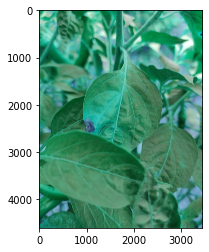

In [ ]:
def display(img_path = "/content/brinjal_chilli_model_data/Chilli/IMG_20220411_110117.jpg"):
    img = cv.imread(img_path) 
    plt.imshow(img)

display( "/content/brinjal_chilli_model_data/Chilli/IMG_20220411_110117.jpg")

In [ ]:

def prepare(filepath):
  IMG_SIZE = 224
  img_array = cv.imread(filepath)
  resized_img_array = cv.resize(img_array, (IMG_SIZE ,IMG_SIZE)) 
  resized_scaled_img_array = resized_img_array/255.0
  # plt.imshow(resized_scaled_img_array) 
  return resized_scaled_img_array.reshape(-1,IMG_SIZE,IMG_SIZE,3 )
  
# model.predict([prepare("/content/brinjal_chilli_model_data/Chilli/IMG20220411110032.jpg")])

## **Testing vs train accuracy**

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

preds = []
preds_log_loss = []
for i, image in enumerate(x_test):
    pred_y = model.predict([prepare(image)])
    preds_log_loss.append(pred_y.ravel())
    preds.append(np.argmax(pred_y))

print("test accuracy:",accuracy_score(y_test, preds))
print("test log loss:",log_loss(y_test, preds_log_loss))

preds = []
preds_log_loss = []
for i, image in enumerate(x_train):
    pred_y = model.predict([prepare(image)])
    preds_log_loss.append(pred_y.ravel())
    preds.append(np.argmax(pred_y))

print("train accuracy:",accuracy_score(y_train, preds))
print("train log loss:",log_loss(y_train, preds_log_loss))

test accuracy: 0.9824561403508771
test log loss: 0.07318871231293683
train accuracy: 0.9928292046936115
train log loss: 0.01760426766610912


# Testing on internet **images**

In [ ]:
#importing pathlib
#please check https://docs.python.org/3/library/pathlib.html  to know about pathlib
import pathlib
data_root = pathlib.Path("/content/testing")

##Getting all image paths
import random
all_test_image_paths = list(data_root.glob('*'))
all_test_image_paths = [str(path) for path in all_test_image_paths]
# ##shuffling the images 
# random.shuffle(all_test_image_paths)

image_count = len(all_test_image_paths)
print("images:",image_count)

y_test_labels = []
for file_path in all_test_image_paths:
    # print(file_path.split('/')[3][0].lower() )
    if file_path.split('/')[3][0].lower() !='b' and file_path.split('/')[3][0].lower() !='c':
      pass
    else:
      y_test_labels.append(0 if file_path.split('/')[3][0].lower() =='b' else 1)

y_test_labels,all_test_image_paths

images: 3


([0, 0, 0],
 ['/content/testing/b2.jpg',
  '/content/testing/b1.jpg',
  '/content/testing/b3.jpeg'])

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss


preds = []
preds_log_loss = []
for i, image in enumerate(all_test_image_paths):
    try:
      pred_y = model.predict([prepare(image)])
      preds_log_loss.append(pred_y.ravel())
      preds.append(np.argmax(pred_y))

    except:
      continue


print("test accuracy:",accuracy_score(y_test_labels, preds))
print("test log loss:",log_loss(y_test_labels, preds_log_loss))


misclassfied_pts = []
for i, label in enumerate(y_test_labels):
  if y_test_labels[i]!=preds[i]:
    misclassfied_pts.append(all_test_image_paths[i])

print("POINTS MISCLASSIFIED:",len(misclassfied_pts),"/",len(all_test_image_paths),"\n")
from google.colab.patches import cv2_imshow
for image in  misclassfied_pts:
  print(image)   
  img = cv.imread(image, cv.IMREAD_UNCHANGED)
  cv2_imshow(img)
  print("\n\n")
  cv.waitKey(0)
  cv.destroyAllWindows()

test accuracy: 0.3333333333333333


ValueError: ignored

# **Saving model**

In [ ]:
model.save('saved_model/mobile_net_98_v2')

INFO:tensorflow:Assets written to: saved_model/mobile_net_98_v2/assets


INFO:tensorflow:Assets written to: saved_model/mobile_net_98_v2/assets


**Uploading model to drive**

In [ ]:
!gsutil cp -r "/content/saved_model/mobile_net_98_v2.h5" "/content/gdrive/MyDrive/saved model"

Copying file:///content/saved_model/mobile_net_98_v2.h5...
/ [1 files][ 89.9 MiB/ 89.9 MiB]                                                
Operation completed over 1 objects/89.9 MiB.                                     


Loading saved model from drive

In [ ]:
import shutil
!gsutil cp -r "/content/gdrive/MyDrive/saved model/mobile_net_98_v2_2.h5" "/content" 

Copying file:///content/gdrive/MyDrive/saved model/mobile_net_98_v2_2.h5...
-
Operation completed over 1 objects/89.9 MiB.                                     


In [ ]:
import shutil
!gsutil cp -r "/content/gdrive/MyDrive/saved model/tflite_model.tflite" "/content" 

Copying file:///content/gdrive/MyDrive/saved model/tflite_model.tflite...
-
Operation completed over 1 objects/45.4 MiB.                                     


In [ ]:
from tensorflow.keras.models import load_model
model = load_model("/content/mobile_net_98")

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (32, 2048)                23500352  
                                                                 
 dropout (Dropout)           (32, 2048)                0         
                                                                 
 output (Dense)              (32, 2)                   4098      
                                                                 
Total params: 23,504,450
Trainable params: 4,098
Non-trainable params: 23,500,352
_________________________________________________________________


In [ ]:
#save
model.save('saved_model/mobile_net_98.h5')
!gsutil cp -r "/content/saved_model/mobile_net_98.h5" "/content/gdrive/MyDrive/test saved models" 

Copying file:///content/saved_model/mobile_net_98.h5...
-
Operation completed over 1 objects/89.9 MiB.                                     


In [ ]:
#save_weights
model.save_weights('/content/saved_model/weights.h5')
!gsutil cp -r "/content/saved_model/weights.h5" "/content/gdrive/MyDrive/test saved models" 

Copying file:///content/saved_model/weights.h5...
-
Operation completed over 1 objects/89.9 MiB.                                     


In [ ]:
import os
# Get file size in bytes for a given model
print("model size",os.stat('/content/saved_model/mobile_net_98.h5').st_size*1e-6,"mb")

model size 94.265552 mb


Reducing size of model (TFlite)

In [ ]:
!gsutil cp -r "/content/tflite_model.tflite" "/content/gdrive/MyDrive/saved model"

Copying file:///content/tflite_model.tflite...
-
Operation completed over 1 objects/45.4 MiB.                                     


# **Post Training Quantization**

In [ ]:
from tensorflow.keras.models import load_model
import tensorflow_hub as hub

model = load_model("/content/mobile_net_98_v2_2.h5",custom_objects={'KerasLayer':hub.KerasLayer})
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
  ]
tf_lite = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpprmc8abl/assets


INFO:tensorflow:Assets written to: /tmp/tmpprmc8abl/assets


In [ ]:
print("model size",len(tf_lite)*1e-6,"mb")

model size 47.651807999999996 mb


In [ ]:
with open("tflite_model.tflite",'wb') as f:
  f.write(tf_lite)

In [ ]:
!gsutil cp -r  "/content/gdrive/MyDrive/saved model/tflite_model.tflite" "/content/"

Copying file:///content/gdrive/MyDrive/saved model/tflite_model.tflite...
-
Operation completed over 1 objects/45.4 MiB.                                     


[0.00136229 0.99863774]


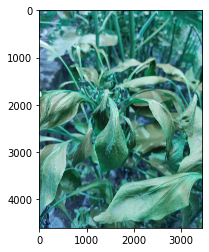

In [ ]:
def test(processed_image):
      # Load TFLite model and allocate tensors.
      interpreter = tf.lite.Interpreter(model_path="/content/tflite_model.tflite")
      interpreter.allocate_tensors()

      # Get input and output tensors.
      input_details = interpreter.get_input_details()
      output_details = interpreter.get_output_details()

      # Test model on some input data.
      input_shape = input_details[0]['shape']
      
      input_data = processed_image.astype('float32')
      interpreter.set_tensor(input_details[0]['index'], input_data)
      interpreter.invoke()
      output_data = interpreter.get_tensor(output_details[0]['index'])
      return output_data.flatten()
 

print(test(prepare(x_test[3])))
display(x_test[3])

In [ ]:


# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="/content/tflite_model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on some input data.
input_shape = input_details[0]['shape']
acc=0
for i in range(len(x_test)):
    input_data = prepare(x_test[i]).astype('float32').reshape(input_shape)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    if(np.argmax(output_data) == y_test[i]):
        acc+=1
acc = acc/len(x_test)
print(acc*100)